In [ ]:
from sklearn.neighbors import NearestNeighbors
import pandas as pd

# 1. Read datasets
spotify_df = pd.read_csv("data/spotify_df_cleaned.csv")
recommendationInfo_df = pd.read_csv("data/recommendation_info.csv")

# 2. Inspect the data in DataFrames
print("Number of rows and columns:", spotify_df.shape)
print("Number of rows and columns:", recommendationInfo_df.shape)

print("Column names:", spotify_df.columns.tolist())
print("Column names:", recommendationInfo_df.columns.tolist())

print("Unique values in host_is_superhost column:", spotify_df['danceability'].unique())


Number of rows and columns: (32828, 21)
Number of rows and columns: (32828, 3)
Column names: ['track_popularity', 'playlist_name', 'playlist_subgenre', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'playlist_genre_edm', 'playlist_genre_latin', 'playlist_genre_pop', 'playlist_genre_r&b', 'playlist_genre_rap', 'playlist_genre_rock']
Column names: ['track_artist', 'track_name', 'track_album_name']


KeyError: 'host_is_superhost'

In [ ]:
# 2. Fit KNN model
X = spotify_df.values   
knn_model = NearestNeighbors(
    metric='cosine',  # cosine similarity works best for music embeddings
    algorithm='brute', 
    n_neighbors=11    # 1 song = itself, + 10 recommendations
)

knn_model.fit(X)

,n_neighbors,11
,radius,1.0
,algorithm,'brute'
,leaf_size,30
,metric,'cosine'
,p,2
,metric_params,None
,n_jobs,None


Path to dataset files: C:\Users\Aaron\.cache\kagglehub\datasets\joebeachcapital\30000-spotify-songs\versions\2
Number of null values in each column track_id                    0
track_name                  5
track_artist                5
track_popularity            0
track_album_id              0
track_album_name            5
track_album_release_date    0
playlist_name               0
playlist_id                 0
playlist_genre              0
playlist_subgenre           0
danceability                0
energy                      0
key                         0
loudness                    0
mode                        0
speechiness                 0
acousticness                0
instrumentalness            0
liveness                    0
valence                     0
tempo                       0
duration_ms                 0
dtype: int64
Number of duplicated values in each column:  0


,track_artist,track_name,track_album_name
0,Ed Sheeran,I Don't Care (with Justin Bieber) - Loud Luxur...,I Don't Care (with Justin Bieber) [Loud Luxury...
1,Maroon 5,Memories - Dillon Francis Remix,Memories (Dillon Francis Remix)
2,Zara Larsson,All the Time - Don Diablo Remix,All the Time (Don Diablo Remix)
3,The Chainsmokers,Call You Mine - Keanu Silva Remix,Call You Mine - The Remixes
4,Lewis Capaldi,Someone You Loved - Future Humans Remix,Someone You Loved (Future Humans Remix)
...,...,...,...
32828,Lush & Simon,City Of Lights - Official Radio Edit,City Of Lights (Vocal Mix)
32829,Tegan and Sara,Closer - Sultan & Ned Shepard Remix,Closer Remixed
32830,Starkillers,Sweet Surrender - Radio Edit,Sweet Surrender (Radio Edit)
32831,Mat Zo,Only For You - Maor Levi Remix,Only For You (Remixes)


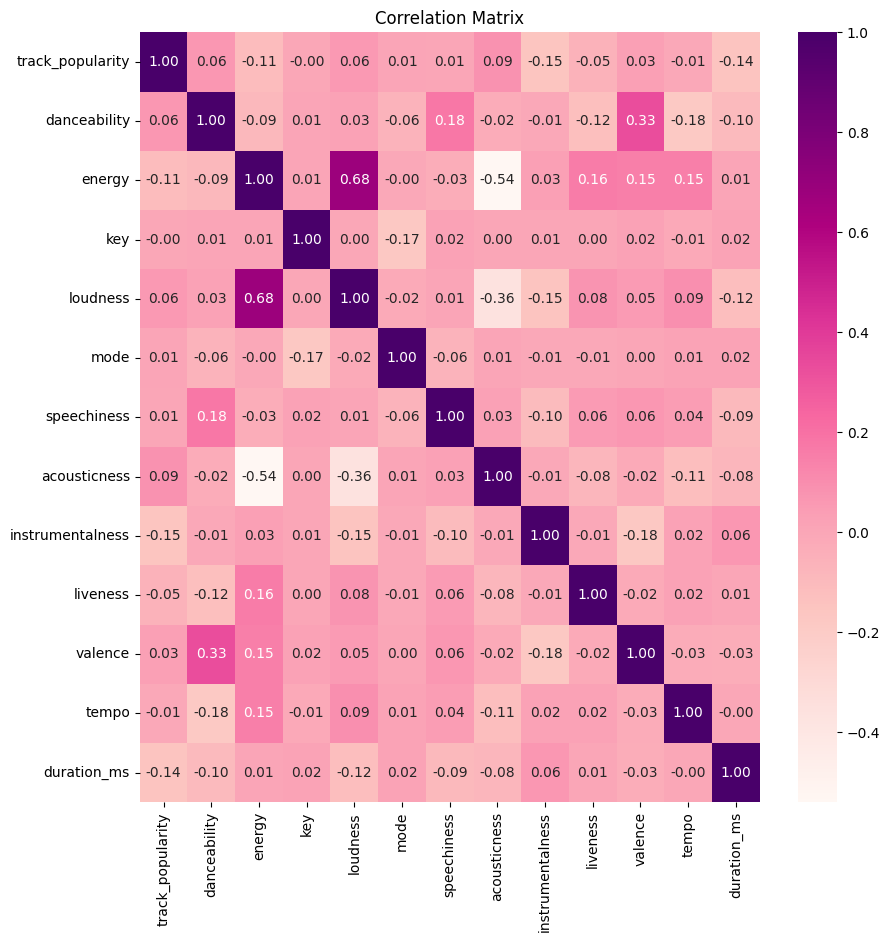

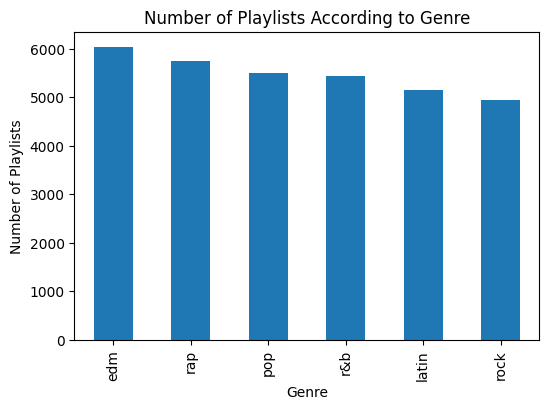

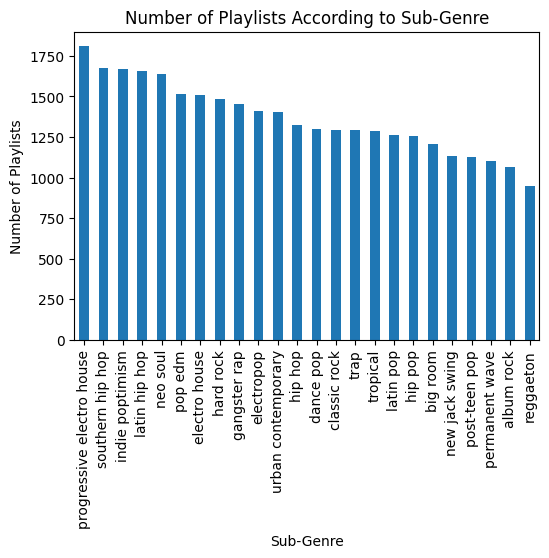

In [ ]:
#load dataset, fix null/duplicated values and remove useless cat cols and save important cat cols. 

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import kagglehub
import os

# Download latest version
path = kagglehub.dataset_download("joebeachcapital/30000-spotify-songs")
print("Path to dataset files:", path)

csv_path = os.path.join(path, "spotify_songs.csv")
spotify_df_full = pd.read_csv(csv_path)

## spotify_df_full = pd.read_csv('data/spotify_songs.csv')

#check num of null values in each feature
print("Number of null values in each column", spotify_df_full.isnull().sum())

#check num of duplicated values in each feature
print("Number of duplicated values in each column: ", spotify_df_full.duplicated().sum())

#drop duplicates & drop null values
spotify_df = spotify_df_full.drop_duplicates().dropna()


#drop categorical values that aren't going to be used
spotify_df = spotify_df.drop(columns=["track_id" , "track_album_id", "track_album_release_date", "playlist_id"])

#save important categorical information in a different df
recommendation_info = spotify_df[['track_artist', 'track_name', 'track_album_name']]
display(recommendation_info)


#see if any values are highly correlated > 0.75 because to prevent inflation of feature importance. 
numerical_cols = spotify_df.select_dtypes(include=['float64', 'int64']).columns
correlation_matrix = spotify_df[numerical_cols].corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation_matrix, annot=True, cmap="RdPu", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


plt.figure(figsize=(6,4))
playlist_genre = spotify_df['playlist_genre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Genre")
plt.title("Number of Playlists According to Genre")


plt.figure(figsize=(6,4))
subgr = spotify_df['playlist_subgenre'].value_counts().plot(kind='bar')
plt.ylabel("Number of Playlists")
plt.xlabel("Sub-Genre")
plt.title("Number of Playlists According to Sub-Genre")

spotify_df = spotify_df.drop(columns=['track_artist', 'track_name', 'track_album_name'])


In [11]:
from sklearn.neighbors import NearestNeighbors

# Convert to numpy matrix for sklearn
X = spotify_df.values

# Build KNN model
knn_model = NearestNeighbors(
    metric="cosine",
    algorithm="brute",
    n_neighbors=11    # 1 = itself, 10 = recommendations
)

knn_model.fit(X)

print("KNN model trained.")

KNN model trained.


In [12]:
def recommend_song(track_name, artist_name, n_recs=10):
    track_name = track_name.lower()
    artist_name = artist_name.lower()

    # Find the song in recommendation_info
    mask = (
        recommendation_info['track_name'].str.lower() == track_name
    ) & (
        recommendation_info['track_artist'].str.lower() == artist_name
    )

    if mask.sum() == 0:
        return "Song not found in dataset."

    song_index = recommendation_info[mask].index[0]

    # Run KNN to find nearest neighbors
    distances, indices = knn_model.kneighbors([X[song_index]], n_neighbors=n_recs + 1)

    # Exclude the first (the song itself)
    rec_indices = indices[0][1:]

    # Return readable song info
    return recommendation_info.iloc[rec_indices].reset_index(drop=True)

In [13]:
recommend_song("Blinding Lights", "The Weeknd")

,track_artist,track_name,track_album_name
0,The Weeknd,Blinding Lights,Blinding Lights
1,Imagine Dragons,Thunder,Evolve
2,OneRepublic,Secrets,Waking Up
3,Linkin Park,Final Masquerade,The Hunting Party
4,Logic,Everyday,Bobby Tarantino II
5,San Holo,Light,Light
6,The Weeknd,Blinding Lights,Blinding Lights
7,Imagine Dragons,Thunder,Evolve
8,K/DA,POP/STARS,POP/STARS
9,Avicii,Without You (feat. Sandro Cavazza),AVĪCI (01)
